In [5]:
import os
import sys
import random
import numpy as np
import pandas as pd
import gzip
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [41]:
import lightgbm as lgb

from sklearn.metrics import mean_squared_error, classification_report, roc_curve, roc_auc_score, auc, confusion_matrix
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve, train_test_split, KFold

# Goal
Here we are analyzing the dataset provided by Avazu for the click through rate of their site domains during the period of about a month.  The data is available [here](https://www.kaggle.com/c/avazu-ctr-prediction/data).  We will look through each of the features provided (as some of them are anonymized and do the necessary engineering to get a good model.

just a helper plot function:

In [3]:
def plotCategory(df, column, only_top10=False):
    
    order = None    
    def indexOrder(df):
        order = list(df.sum(axis=1).sort_values(ascending=False).index)
        df.index = df.index.str.strip()
        return order, df.reindex(order)

    if only_top10:
        df = df[df[column].isin((df[column].value_counts()/len(df))[0:10].index)]
        df_click = df.groupby([column, 'click']).size().unstack()
        order, df_click = indexOrder(df_click)
    else:
        df_click = df.groupby([column, 'click']).size().unstack()
        
    fig, ax = plt.subplots(2, 1, figsize=(12,6), sharex=True)
    df_click.plot(kind='bar', ax=ax[0])
    ax[0].set_ylabel('count')
    ax[0].set_title('{} clicks by category'.format(column))

    sns.catplot(x=column, y='click', data=df, kind='bar', ax=ax[1], order=order)
    ax[1].set_title('CTR by {}'.format(column))
    plt.close(2)

In [4]:
n_train = 40428967
sample_size = 250000
random.seed(9623)
skip_values = sorted(random.sample(range(1, n_train), n_train-sample_size)) 

In [6]:
date_parse_fcn = lambda val : pd.datetime.strptime(val, '%y%m%d%H')

In [7]:
with gzip.open('data/train.gz') as f:
    df = pd.read_csv(f, parse_dates=['hour'], date_parser=date_parse_fcn, skiprows=skip_values)

data = df.copy()
df.head()

,id,click,hour,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,...,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21
0,10055435465659353593,0,2014-10-21,1005,0,518d6168,92c9e92d,f028772b,ecad2386,7801e8d9,...,1,0,18993,320,50,2161,0,35,-1,157
1,10102252276250523887,0,2014-10-21,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,...,1,0,15703,320,50,1722,0,35,-1,79
2,10145340387083720079,0,2014-10-21,1005,0,85f751fd,c4e18dd6,50e219e0,1779deee,2347f47a,...,1,0,20596,320,50,2161,0,35,-1,157
3,10158357963097250581,0,2014-10-21,1010,1,85f751fd,c4e18dd6,50e219e0,c7f29df3,7801e8d9,...,4,0,21665,320,50,2493,3,35,100050,117
4,10177862548969891071,0,2014-10-21,1010,1,85f751fd,c4e18dd6,50e219e0,ffc6ffd0,7801e8d9,...,4,0,21665,320,50,2493,3,35,-1,117


In [10]:
df.shape

(250000, 26)

In [8]:
df.dtypes

id                          uint64
click                        int64
hour                datetime64[ns]
C1                           int64
banner_pos                   int64
site_id                     object
site_domain                 object
site_category               object
app_id                      object
app_domain                  object
app_category                object
device_id                   object
device_ip                   object
device_model                object
device_type                  int64
device_conn_type             int64
C14                          int64
C15                          int64
C16                          int64
C17                          int64
C18                          int64
C19                          int64
C20                          int64
C21                          int64
dtype: object

In [9]:
df.nunique()

id                  250000
click                    2
hour                   240
C1                       7
banner_pos               7
site_id               1937
site_domain           1881
site_category           21
app_id                1864
app_domain             131
app_category            24
device_id            40797
device_ip           174522
device_model          3979
device_type              4
device_conn_type         4
C14                   1958
C15                      8
C16                      9
C17                    411
C18                      4
C19                     64
C20                    161
C21                     60
dtype: int64

In [10]:
df.hour.describe()

count                  250000
unique                    240
top       2014-10-22 09:00:00
freq                     2774
first     2014-10-21 00:00:00
last      2014-10-30 23:00:00
Name: hour, dtype: object

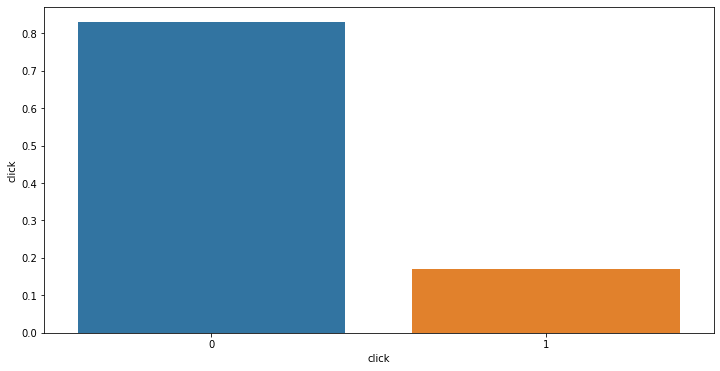

In [11]:
plt.subplots(figsize=(12,6))
sns.barplot(x='click', y='click', data=df, estimator=lambda x: len(x)/len(df))

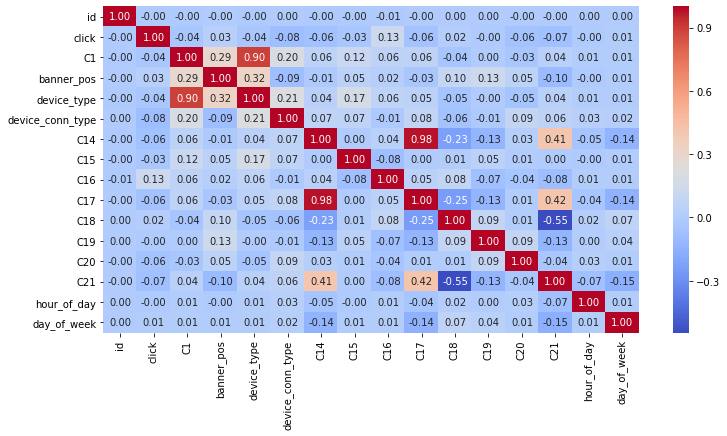

In [11]:
fig, ax = plt.subplots(figsize=(12,6))
sns.heatmap(df.corr(), 
                  fmt=".2f", annot=True, cmap="coolwarm")
plt.close(2)

Text(0.5, 1.0, 'Clicks by Hour')

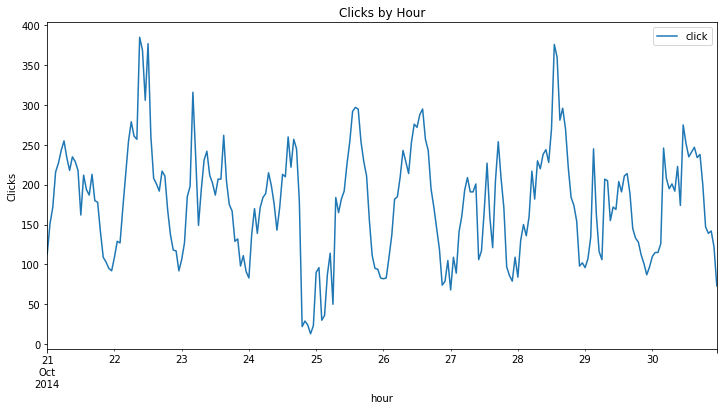

In [12]:
df.groupby('hour').agg({'click':'sum'}).plot(figsize=(12,6))
plt.ylabel('Clicks')
plt.title('Clicks by Hour')

In [8]:
df['hour_of_day'] = df.hour.apply(lambda x: x.hour)

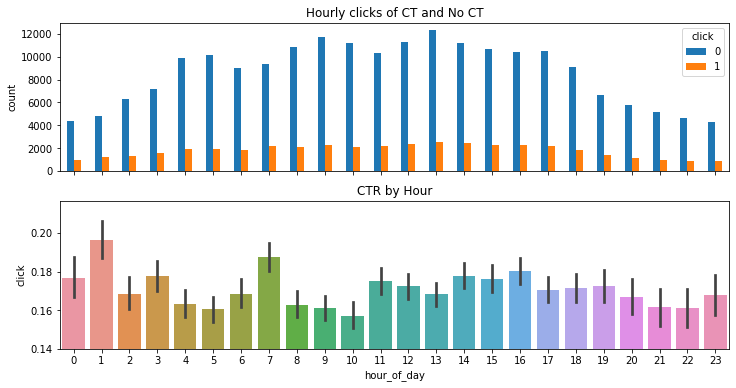

In [14]:
fig, ax = plt.subplots(2, 1, figsize=(12,6), sharex=True)
df.groupby(['hour_of_day', 'click']).size().unstack().plot(kind='bar', ax=ax[0])
ax[0].set_ylabel('count')
ax[0].set_title('Hourly clicks of CT and No CT')

sns.catplot(x='hour_of_day', y='click', data=df, kind='bar', ax=ax[1])
ax[1].set_ylim([0.14, None])
ax[1].set_title('CTR by Hour')
plt.close(2)

In [8]:
cats = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

df['day_of_week'] = df['hour'].apply(lambda x: x.strftime('%A'))
df['day_of_week'] = pd.Categorical(df['day_of_week'], categories=cats, ordered=True)

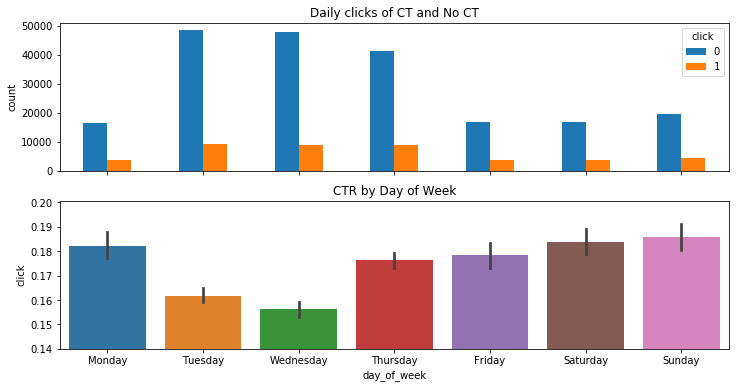

In [16]:
fig, ax = plt.subplots(2, 1, figsize=(12,6), sharex=True)
df.groupby(['day_of_week', 'click']).size().unstack().plot(kind='bar', ax=ax[0])
ax[0].set_ylabel('count')
ax[0].set_title('Daily clicks of CT and No CT')

sns.catplot(x='day_of_week', y='click', data=df, kind='bar', ax=ax[1])
ax[1].set_ylim([0.14, None])
ax[1].set_title('CTR by Day of Week')
plt.close(2)

### C1

In [17]:
df.C1.value_counts()/len(df)

1005    0.918576
1002    0.054956
1010    0.022448
1012    0.002848
1007    0.000844
1001    0.000212
1008    0.000116
Name: C1, dtype: float64

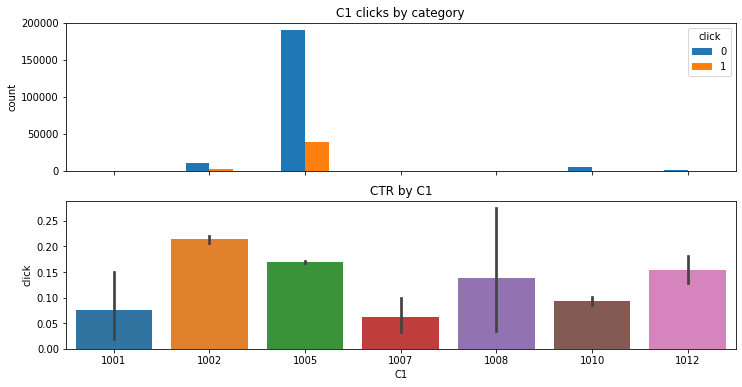

In [18]:
plotCategory(df, 'C1', only_top10=False)

### Banner Position

In [19]:
df.banner_pos.value_counts()/len(df)

0    0.720592
1    0.277604
7    0.001144
2    0.000296
4    0.000196
5    0.000116
3    0.000052
Name: banner_pos, dtype: float64

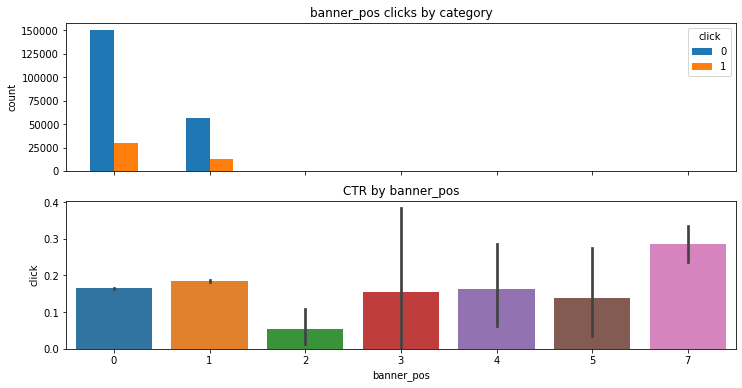

In [20]:
plotCategory(df, 'banner_pos')

### Site ID

In [21]:
(df.site_id.value_counts()/len(df))[0:10]

85f751fd    0.360696
1fbe01fe    0.161512
e151e245    0.065548
d9750ee7    0.023840
5b08c53b    0.022712
856e6d3f    0.019128
5b4d2eda    0.018492
a7853007    0.011424
b7e9786d    0.009140
5ee41ff2    0.008612
Name: site_id, dtype: float64

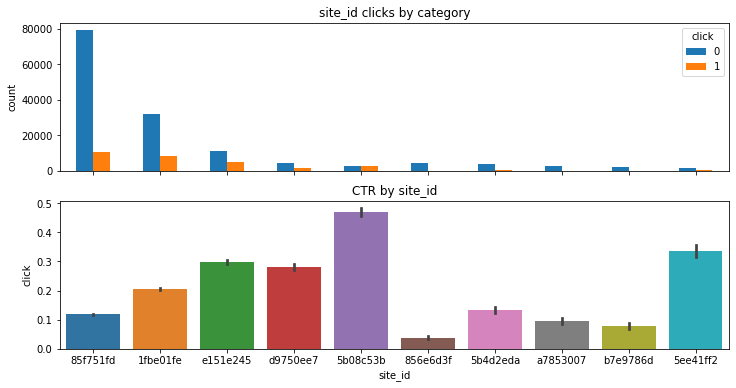

In [22]:
plotCategory(df, 'site_id', only_top10=True)

### Site Domain

In [23]:
(df.site_domain.value_counts()/len(df))[0:10]

c4e18dd6    0.373740
f3845767    0.161512
7e091613    0.082676
7687a86e    0.032108
98572c79    0.024632
16a36ef3    0.020488
58a89a43    0.019128
9d54950b    0.009508
b12b9f85    0.009236
17d996e6    0.008736
Name: site_domain, dtype: float64

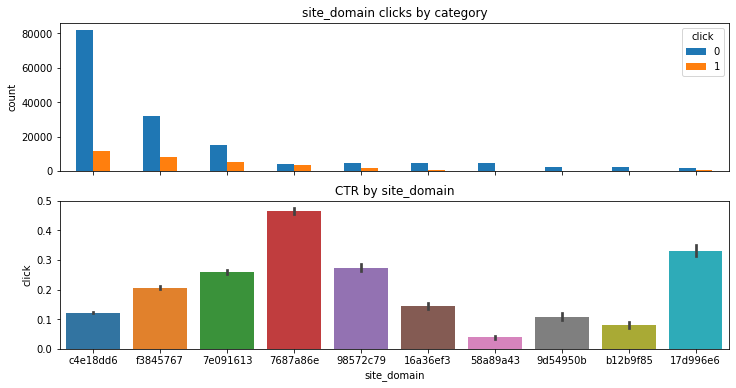

In [24]:
plotCategory(df, 'site_domain', only_top10=True)

### Site Category

In [25]:
(df.site_category.value_counts()/len(df))[0:10]

50e219e0    0.408704
f028772b    0.312240
28905ebd    0.183328
3e814130    0.075508
f66779e6    0.006188
75fa27f6    0.004052
335d28a8    0.003464
76b2941d    0.002612
c0dd3be3    0.000988
72722551    0.000808
Name: site_category, dtype: float64

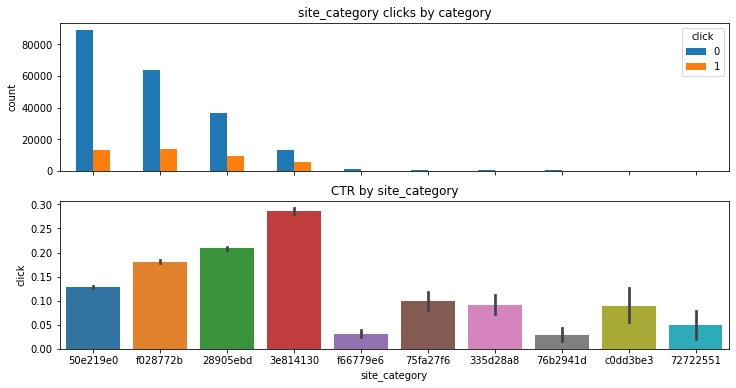

In [26]:
plotCategory(df, 'site_category', only_top10=True)

### Device ID

In [27]:
(df.device_id.value_counts()/len(df))[0:10]

a99f214a    0.826076
0f7c61dc    0.000568
c357dbff    0.000472
936e92fb    0.000328
afeffc18    0.000212
d857ffbb    0.000124
28dc8687    0.000120
b09da1c4    0.000088
3cdb4052    0.000088
987552d1    0.000084
Name: device_id, dtype: float64

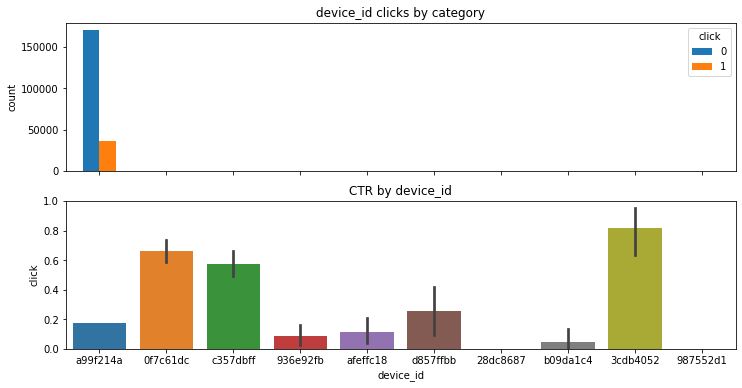

In [28]:
plotCategory(df, 'device_id', only_top10=True)

### Device Type

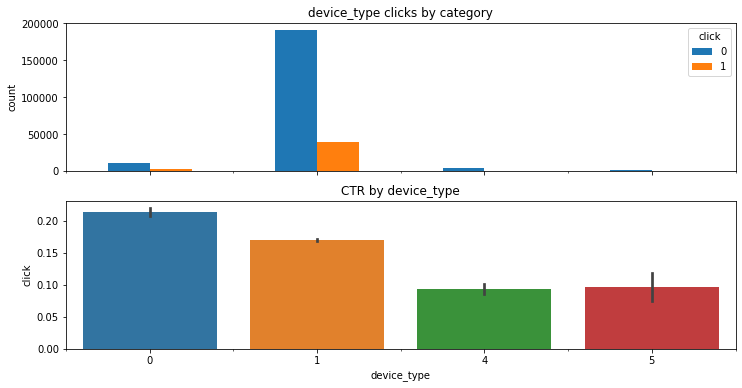

In [29]:
plotCategory(df, 'device_type', only_top10=False)

### App Category

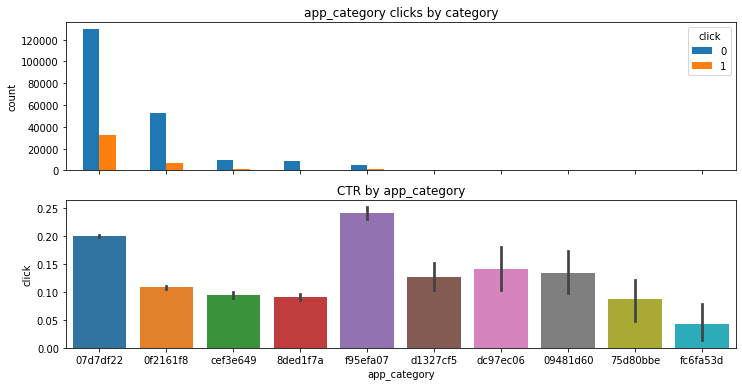

In [30]:
plotCategory(df, 'app_category', only_top10=True)

## Feature Engineering
We are just going to use a hash encoder here to avoid the ordinality problem created by using a typical label encoder

In [9]:
df.nunique()

id                  250000
click                    2
hour                   240
C1                       7
banner_pos               7
site_id               1901
site_domain           1844
site_category           21
app_id                1926
app_domain             131
app_category            25
device_id            41149
device_ip           174601
device_model          3943
device_type              5
device_conn_type         4
C14                   1977
C15                      8
C16                      9
C17                    412
C18                      4
C19                     66
C20                    158
C21                     60
hour_of_day             24
dtype: int64

In [10]:
df['day_of_week'] = df['hour'].apply(lambda x: x.weekday())

In [12]:
df.drop(['hour', 'id', 'device_id', 'device_ip', 'site_domain'], axis=1, inplace=True)

In [13]:
le = LabelEncoder()
dummy_columns = [] 

for column in df.columns:
    if df[column].dtype == object:
        if df[column].nunique() == 2:
            df[column] = le.fit_transform(df[column]) 
        else:
            dummy_columns.append(column)

df = pd.get_dummies(data=df, columns=dummy_columns)
df.head()

,click,C1,banner_pos,device_type,device_conn_type,C14,C15,C16,C17,C18,...,device_model_ff717dd1,device_model_ff91ea03,device_model_ff9df0b2,device_model_ffb16766,device_model_ffc70ef9,device_model_ffcd1497,device_model_ffceddb3,device_model_ffe3ae81,device_model_ffe69079,device_model_ffeafe15
0,0,1005,0,1,0,18993,320,50,2161,0,...,0,0,0,0,0,0,0,0,0,0
1,0,1005,0,1,0,15703,320,50,1722,0,...,0,0,0,0,0,0,0,0,0,0
2,0,1005,0,1,0,20596,320,50,2161,0,...,0,0,0,0,0,0,0,0,0,0
3,0,1010,1,4,0,21665,320,50,2493,3,...,0,0,0,0,0,0,0,0,0,0
4,0,1010,1,4,0,21665,320,50,2493,3,...,0,0,0,0,0,0,0,0,0,0


In [14]:
df.shape

(250000, 7962)

## Model
### Preparation

In [15]:
X = df.drop(['click'], axis=1)
y = df.click.values

In [16]:
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, random_state=561)
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.2, random_state=561)

### LightGBM

In [17]:
lgb_train = lgb.Dataset(X_train, label=y_train)
lgb_eval = lgb.Dataset(X_val, y_val, reference=lgb_train)

In [22]:
params = {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': { 'binary_logloss'},
    'num_leaves': 31, # default
    'learning_rate': 0.01,
    'feature_fraction': 0.75,
    'bagging_fraction': 0.35,
    'bagging_freq': 10,
    'verbose': 0,
    'num_threads': 4
}

gbm = lgb.train(params,
                lgb_train,
                num_boost_round=2000,
                valid_sets=lgb_eval,
                early_stopping_rounds=500)

[1]	valid_0's binary_logloss: 0.456767
Training until validation scores don't improve for 500 rounds.
[2]	valid_0's binary_logloss: 0.456088
[3]	valid_0's binary_logloss: 0.455444
[4]	valid_0's binary_logloss: 0.45483
[5]	valid_0's binary_logloss: 0.454188
[6]	valid_0's binary_logloss: 0.453627
[7]	valid_0's binary_logloss: 0.453036
[8]	valid_0's binary_logloss: 0.452425
[9]	valid_0's binary_logloss: 0.451842
[10]	valid_0's binary_logloss: 0.45128
[11]	valid_0's binary_logloss: 0.450674
[12]	valid_0's binary_logloss: 0.450084
[13]	valid_0's binary_logloss: 0.449549
[14]	valid_0's binary_logloss: 0.448992
[15]	valid_0's binary_logloss: 0.448452
[16]	valid_0's binary_logloss: 0.447906
[17]	valid_0's binary_logloss: 0.447386
[18]	valid_0's binary_logloss: 0.446879
[19]	valid_0's binary_logloss: 0.446391
[20]	valid_0's binary_logloss: 0.44592
[21]	valid_0's binary_logloss: 0.445473
[22]	valid_0's binary_logloss: 0.444985
[23]	valid_0's binary_logloss: 0.44453
[24]	valid_0's binary_logloss:

[205]	valid_0's binary_logloss: 0.415474
[206]	valid_0's binary_logloss: 0.415421
[207]	valid_0's binary_logloss: 0.415365
[208]	valid_0's binary_logloss: 0.415306
[209]	valid_0's binary_logloss: 0.41525
[210]	valid_0's binary_logloss: 0.415196
[211]	valid_0's binary_logloss: 0.415147
[212]	valid_0's binary_logloss: 0.415105
[213]	valid_0's binary_logloss: 0.415051
[214]	valid_0's binary_logloss: 0.415003
[215]	valid_0's binary_logloss: 0.414967
[216]	valid_0's binary_logloss: 0.414926
[217]	valid_0's binary_logloss: 0.414877
[218]	valid_0's binary_logloss: 0.414831
[219]	valid_0's binary_logloss: 0.414789
[220]	valid_0's binary_logloss: 0.414748
[221]	valid_0's binary_logloss: 0.414701
[222]	valid_0's binary_logloss: 0.414653
[223]	valid_0's binary_logloss: 0.414612
[224]	valid_0's binary_logloss: 0.414563
[225]	valid_0's binary_logloss: 0.414523
[226]	valid_0's binary_logloss: 0.414481
[227]	valid_0's binary_logloss: 0.414442
[228]	valid_0's binary_logloss: 0.414399
[229]	valid_0's b

[417]	valid_0's binary_logloss: 0.409881
[418]	valid_0's binary_logloss: 0.409866
[419]	valid_0's binary_logloss: 0.409851
[420]	valid_0's binary_logloss: 0.409836
[421]	valid_0's binary_logloss: 0.409818
[422]	valid_0's binary_logloss: 0.409802
[423]	valid_0's binary_logloss: 0.409776
[424]	valid_0's binary_logloss: 0.409757
[425]	valid_0's binary_logloss: 0.409739
[426]	valid_0's binary_logloss: 0.409715
[427]	valid_0's binary_logloss: 0.409699
[428]	valid_0's binary_logloss: 0.409674
[429]	valid_0's binary_logloss: 0.409654
[430]	valid_0's binary_logloss: 0.409639
[431]	valid_0's binary_logloss: 0.409627
[432]	valid_0's binary_logloss: 0.409609
[433]	valid_0's binary_logloss: 0.409592
[434]	valid_0's binary_logloss: 0.409573
[435]	valid_0's binary_logloss: 0.40956
[436]	valid_0's binary_logloss: 0.409543
[437]	valid_0's binary_logloss: 0.409534
[438]	valid_0's binary_logloss: 0.409518
[439]	valid_0's binary_logloss: 0.409503
[440]	valid_0's binary_logloss: 0.409491
[441]	valid_0's b

[618]	valid_0's binary_logloss: 0.407709
[619]	valid_0's binary_logloss: 0.407699
[620]	valid_0's binary_logloss: 0.407685
[621]	valid_0's binary_logloss: 0.407675
[622]	valid_0's binary_logloss: 0.407666
[623]	valid_0's binary_logloss: 0.407652
[624]	valid_0's binary_logloss: 0.407637
[625]	valid_0's binary_logloss: 0.407624
[626]	valid_0's binary_logloss: 0.407615
[627]	valid_0's binary_logloss: 0.407605
[628]	valid_0's binary_logloss: 0.407596
[629]	valid_0's binary_logloss: 0.407582
[630]	valid_0's binary_logloss: 0.407577
[631]	valid_0's binary_logloss: 0.407565
[632]	valid_0's binary_logloss: 0.407556
[633]	valid_0's binary_logloss: 0.407547
[634]	valid_0's binary_logloss: 0.407536
[635]	valid_0's binary_logloss: 0.407525
[636]	valid_0's binary_logloss: 0.407516
[637]	valid_0's binary_logloss: 0.407508
[638]	valid_0's binary_logloss: 0.407503
[639]	valid_0's binary_logloss: 0.407492
[640]	valid_0's binary_logloss: 0.407486
[641]	valid_0's binary_logloss: 0.407474
[642]	valid_0's 

[823]	valid_0's binary_logloss: 0.40672
[824]	valid_0's binary_logloss: 0.406714
[825]	valid_0's binary_logloss: 0.406706
[826]	valid_0's binary_logloss: 0.406702
[827]	valid_0's binary_logloss: 0.406698
[828]	valid_0's binary_logloss: 0.40669
[829]	valid_0's binary_logloss: 0.406685
[830]	valid_0's binary_logloss: 0.406679
[831]	valid_0's binary_logloss: 0.406677
[832]	valid_0's binary_logloss: 0.406672
[833]	valid_0's binary_logloss: 0.40667
[834]	valid_0's binary_logloss: 0.406669
[835]	valid_0's binary_logloss: 0.406661
[836]	valid_0's binary_logloss: 0.406657
[837]	valid_0's binary_logloss: 0.406657
[838]	valid_0's binary_logloss: 0.406654
[839]	valid_0's binary_logloss: 0.40665
[840]	valid_0's binary_logloss: 0.406647
[841]	valid_0's binary_logloss: 0.406641
[842]	valid_0's binary_logloss: 0.406637
[843]	valid_0's binary_logloss: 0.406629
[844]	valid_0's binary_logloss: 0.406623
[845]	valid_0's binary_logloss: 0.406619
[846]	valid_0's binary_logloss: 0.406616
[847]	valid_0's bina

[1026]	valid_0's binary_logloss: 0.406038
[1027]	valid_0's binary_logloss: 0.406037
[1028]	valid_0's binary_logloss: 0.406038
[1029]	valid_0's binary_logloss: 0.406038
[1030]	valid_0's binary_logloss: 0.406038
[1031]	valid_0's binary_logloss: 0.406039
[1032]	valid_0's binary_logloss: 0.406035
[1033]	valid_0's binary_logloss: 0.406034
[1034]	valid_0's binary_logloss: 0.406036
[1035]	valid_0's binary_logloss: 0.406034
[1036]	valid_0's binary_logloss: 0.406037
[1037]	valid_0's binary_logloss: 0.406037
[1038]	valid_0's binary_logloss: 0.406036
[1039]	valid_0's binary_logloss: 0.406041
[1040]	valid_0's binary_logloss: 0.406041
[1041]	valid_0's binary_logloss: 0.406042
[1042]	valid_0's binary_logloss: 0.40604
[1043]	valid_0's binary_logloss: 0.406037
[1044]	valid_0's binary_logloss: 0.406036
[1045]	valid_0's binary_logloss: 0.406032
[1046]	valid_0's binary_logloss: 0.406031
[1047]	valid_0's binary_logloss: 0.406032
[1048]	valid_0's binary_logloss: 0.406036
[1049]	valid_0's binary_logloss: 0.

[1222]	valid_0's binary_logloss: 0.405489
[1223]	valid_0's binary_logloss: 0.405485
[1224]	valid_0's binary_logloss: 0.405479
[1225]	valid_0's binary_logloss: 0.405472
[1226]	valid_0's binary_logloss: 0.405464
[1227]	valid_0's binary_logloss: 0.405462
[1228]	valid_0's binary_logloss: 0.405455
[1229]	valid_0's binary_logloss: 0.405454
[1230]	valid_0's binary_logloss: 0.405451
[1231]	valid_0's binary_logloss: 0.405449
[1232]	valid_0's binary_logloss: 0.405442
[1233]	valid_0's binary_logloss: 0.405434
[1234]	valid_0's binary_logloss: 0.405434
[1235]	valid_0's binary_logloss: 0.405434
[1236]	valid_0's binary_logloss: 0.405432
[1237]	valid_0's binary_logloss: 0.405433
[1238]	valid_0's binary_logloss: 0.40543
[1239]	valid_0's binary_logloss: 0.405428
[1240]	valid_0's binary_logloss: 0.405425
[1241]	valid_0's binary_logloss: 0.405424
[1242]	valid_0's binary_logloss: 0.405421
[1243]	valid_0's binary_logloss: 0.405413
[1244]	valid_0's binary_logloss: 0.405408
[1245]	valid_0's binary_logloss: 0.

[1420]	valid_0's binary_logloss: 0.405183
[1421]	valid_0's binary_logloss: 0.405181
[1422]	valid_0's binary_logloss: 0.40518
[1423]	valid_0's binary_logloss: 0.40518
[1424]	valid_0's binary_logloss: 0.40518
[1425]	valid_0's binary_logloss: 0.40518
[1426]	valid_0's binary_logloss: 0.405179
[1427]	valid_0's binary_logloss: 0.405176
[1428]	valid_0's binary_logloss: 0.405176
[1429]	valid_0's binary_logloss: 0.405177
[1430]	valid_0's binary_logloss: 0.405178
[1431]	valid_0's binary_logloss: 0.405175
[1432]	valid_0's binary_logloss: 0.405177
[1433]	valid_0's binary_logloss: 0.405178
[1434]	valid_0's binary_logloss: 0.405175
[1435]	valid_0's binary_logloss: 0.405179
[1436]	valid_0's binary_logloss: 0.40518
[1437]	valid_0's binary_logloss: 0.405183
[1438]	valid_0's binary_logloss: 0.405182
[1439]	valid_0's binary_logloss: 0.405182
[1440]	valid_0's binary_logloss: 0.40518
[1441]	valid_0's binary_logloss: 0.405176
[1442]	valid_0's binary_logloss: 0.405172
[1443]	valid_0's binary_logloss: 0.40516

[1619]	valid_0's binary_logloss: 0.405085
[1620]	valid_0's binary_logloss: 0.405084
[1621]	valid_0's binary_logloss: 0.405081
[1622]	valid_0's binary_logloss: 0.405078
[1623]	valid_0's binary_logloss: 0.405075
[1624]	valid_0's binary_logloss: 0.405068
[1625]	valid_0's binary_logloss: 0.405067
[1626]	valid_0's binary_logloss: 0.405066
[1627]	valid_0's binary_logloss: 0.405065
[1628]	valid_0's binary_logloss: 0.405064
[1629]	valid_0's binary_logloss: 0.405061
[1630]	valid_0's binary_logloss: 0.405057
[1631]	valid_0's binary_logloss: 0.405055
[1632]	valid_0's binary_logloss: 0.405052
[1633]	valid_0's binary_logloss: 0.40505
[1634]	valid_0's binary_logloss: 0.405048
[1635]	valid_0's binary_logloss: 0.405045
[1636]	valid_0's binary_logloss: 0.405044
[1637]	valid_0's binary_logloss: 0.405042
[1638]	valid_0's binary_logloss: 0.405041
[1639]	valid_0's binary_logloss: 0.405041
[1640]	valid_0's binary_logloss: 0.405038
[1641]	valid_0's binary_logloss: 0.405036
[1642]	valid_0's binary_logloss: 0.

[1819]	valid_0's binary_logloss: 0.404966
[1820]	valid_0's binary_logloss: 0.404964
[1821]	valid_0's binary_logloss: 0.40496
[1822]	valid_0's binary_logloss: 0.404959
[1823]	valid_0's binary_logloss: 0.404961
[1824]	valid_0's binary_logloss: 0.404957
[1825]	valid_0's binary_logloss: 0.404956
[1826]	valid_0's binary_logloss: 0.404955
[1827]	valid_0's binary_logloss: 0.404956
[1828]	valid_0's binary_logloss: 0.404955
[1829]	valid_0's binary_logloss: 0.404952
[1830]	valid_0's binary_logloss: 0.404953
[1831]	valid_0's binary_logloss: 0.404954
[1832]	valid_0's binary_logloss: 0.404954
[1833]	valid_0's binary_logloss: 0.404959
[1834]	valid_0's binary_logloss: 0.404961
[1835]	valid_0's binary_logloss: 0.404963
[1836]	valid_0's binary_logloss: 0.40497
[1837]	valid_0's binary_logloss: 0.404971
[1838]	valid_0's binary_logloss: 0.404976
[1839]	valid_0's binary_logloss: 0.404978
[1840]	valid_0's binary_logloss: 0.404986
[1841]	valid_0's binary_logloss: 0.404984
[1842]	valid_0's binary_logloss: 0.4

In [23]:
y_pred = gbm.predict(X_test, num_iteration=gbm.best_iteration)

In [25]:
print('The rmse of prediction is:', mean_squared_error(y_test, y_pred) ** 0.5)

The rmse of prediction is: 0.3550641933433959


In [33]:
confusion_matrix(y_test, np.round(y_pred))

array([[41162,   384],
       [ 7905,   549]], dtype=int64)

In [29]:
print(classification_report(y_test, np.round(y_pred)))

              precision    recall  f1-score   support

           0       0.84      0.99      0.91     41546
           1       0.59      0.06      0.12      8454

    accuracy                           0.83     50000
   macro avg       0.71      0.53      0.51     50000
weighted avg       0.80      0.83      0.77     50000



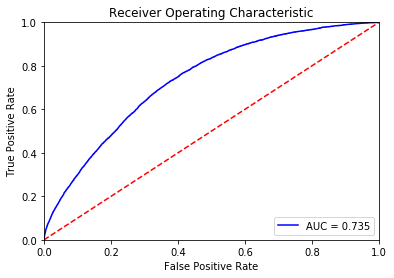

In [32]:
fpr, tpr, threshold = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

# method I: plt
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.3f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()


Unfortunately we do not have insight as to what the anonymized features are.  However, our datetime features were important to fitting the model.  If the data was provided over a larger date range sequential features could be added such as month or season. Of course, some markets are seasonal and this would be a good feature in some business domains.  In addition, the banner position of ads is important as expected.

Plotting feature importances...


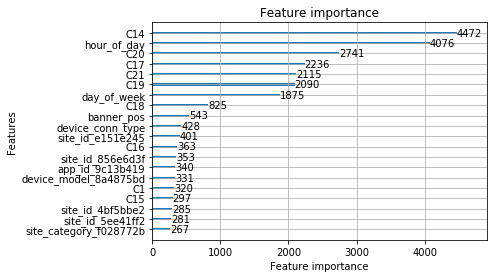

In [34]:
print('Plotting feature importances...')
ax = lgb.plot_importance(gbm, max_num_features=20)
plt.show()

### Random Forest

In [36]:
np.sqrt(X_train.shape[1])

89.22443611477743

In [38]:
params = {
        'max_depth': [3, 10],
        'max_features': [25, 50, int(np.sqrt(X_train.shape[1]))]
}
RF = RandomForestClassifier(n_estimators=100, criterion='gini', min_samples_split=25)
grid_search = GridSearchCV(RF, params, cv=3, scoring='roc_auc')
grid_search.fit(X_train, y_train)

GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=25,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              random_state=None, verbose=0,
                                              warm_start=False),
             iid='

In [39]:
print("Best: %f using %s" % (grid_search.best_score_, grid_search.best_params_))

Best: 0.673159 using {'max_depth': 10, 'max_features': 89}


In [42]:
RF_final = grid_search.best_estimator_

y_pred = RF_final.predict_proba(X_test)[:, 1]
score = roc_auc_score(y_test, y_pred)
print('ROC AUC score on test set: {0:.3f}'.format(score))

ROC AUC score on test set: 0.670


In [45]:
print(classification_report(y_test, np.round(y_pred)))

              precision    recall  f1-score   support

           0       0.83      1.00      0.91     41546
           1       0.00      0.00      0.00      8454

    accuracy                           0.83     50000
   macro avg       0.42      0.50      0.45     50000
weighted avg       0.69      0.83      0.75     50000



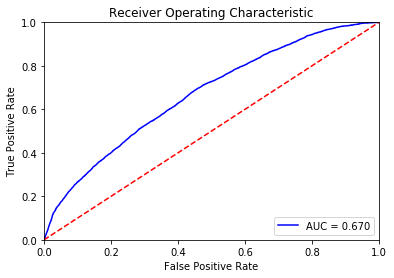

In [46]:
fpr, tpr, threshold = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

# method I: plt
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.3f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()